In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


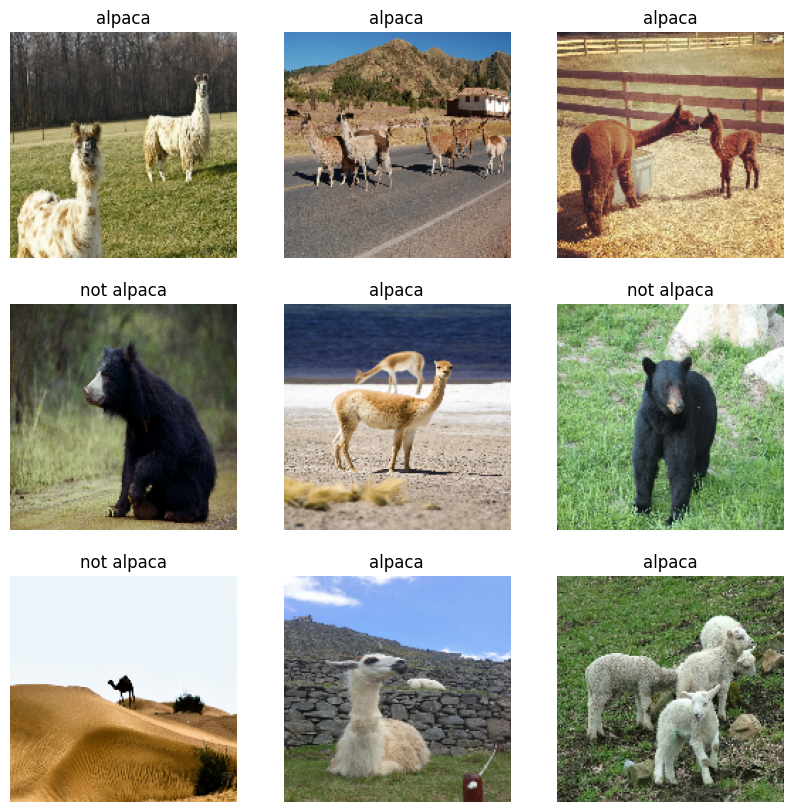

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

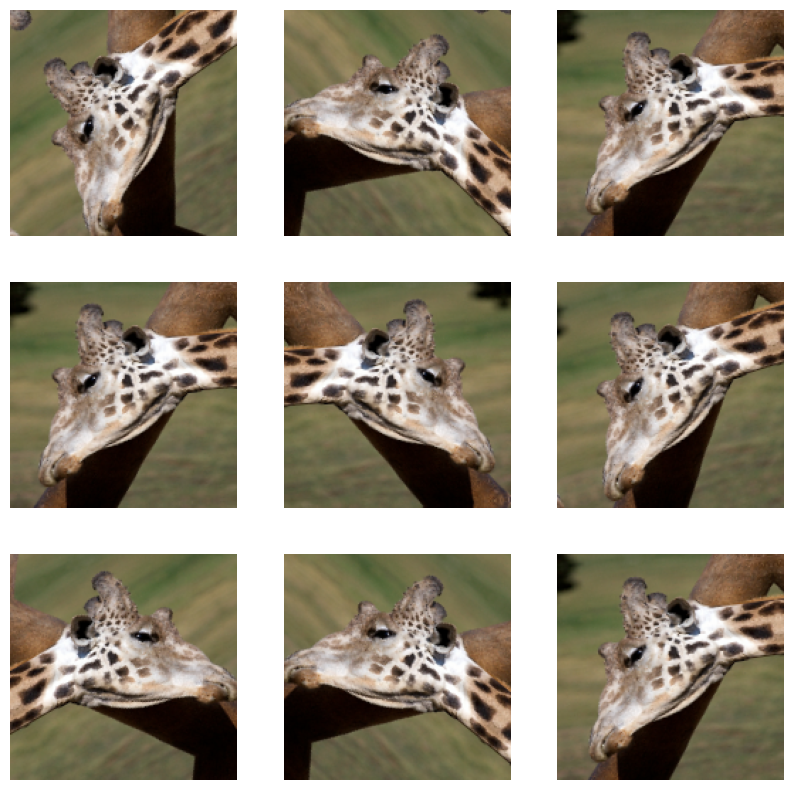

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [15]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.10330015),
  ('n02102177', 'Welsh_springer_spaniel', 0.078835174)],
 [('n02125311', 'cougar', 0.16546737), ('n02389026', 'sorrel', 0.10764251)],
 [('n02437312', 'Arabian_camel', 0.29232892),
  ('n02437616', 'llama', 0.2771344)],
 [('n03944341', 'pinwheel', 0.3115496), ('n03047690', 'clog', 0.052499797)],
 [('n02454379', 'armadillo', 0.7310713), ('n01990800', 'isopod', 0.038720097)],
 [('n02437312', 'Arabian_camel', 0.2566376),
  ('n02422106', 'hartebeest', 0.1212272)],
 [('n02437616', 'llama', 0.6612569),
  ('n02090721', 'Irish_wolfhound', 0.23782717)],
 [('n02133161', 'American_black_bear', 0.8273564),
  ('n02134418', 'sloth_bear', 0.029259564)],
 [('n01518878', 'ostrich', 0.9267561),
  ('n02002724', 'black_stork', 0.0017766313)],
 [('n01518878', 'ostrich', 0.94954574),
  ('n02018795', 'bustard', 0.0028661601)],
 [('n02437616', 'llama', 0.869984), ('n02412080', 'ram', 0.07675682)],
 [('n02415577', 'bighorn', 0.24294446), ('n02412080', 'ram', 0.160

In [16]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)

    outputs = tfl.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [17]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [18]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [20]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 10s 287ms/step - loss: 0.7758 - accuracy: 0.5611 - val_loss: 0.5001 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 3s 98ms/step - loss: 0.6205 - accuracy: 0.6450 - val_loss: 0.5055 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 5s 200ms/step - loss: 0.4855 - accuracy: 0.7176 - val_loss: 0.4164 - val_accuracy: 0.6769
Epoch 4/5
9/9 [==============================] - 3s 100ms/step - loss: 0.4878 - accuracy: 0.7252 - val_loss: 0.3934 - val_accuracy: 0.6615
Epoch 5/5
9/9 [==============================] - 3s 94ms/step - loss: 0.4212 - accuracy: 0.7786 - val_loss: 0.3214 - val_accuracy: 0.7846


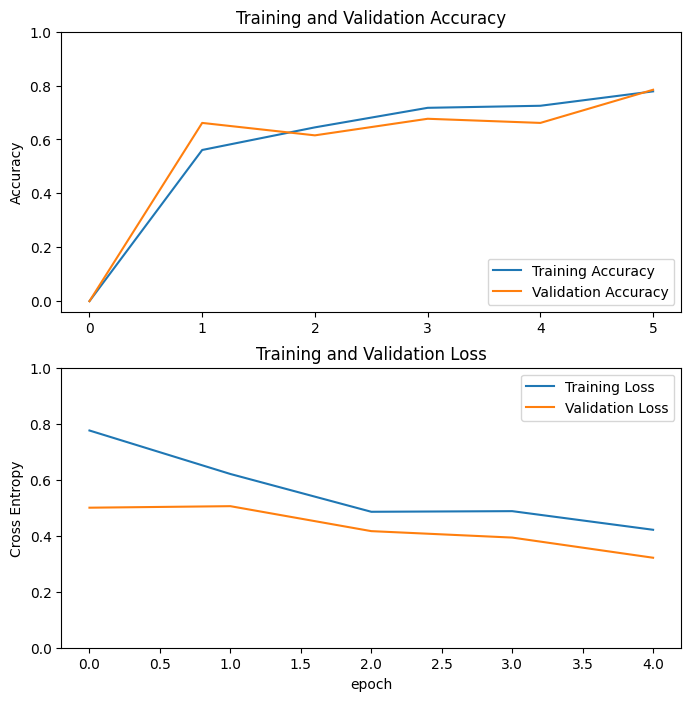

In [21]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['alpaca', 'not alpaca']

In [23]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = True

loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

metrics = ['accuracy']

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

Number of layers in the base model:  154


In [24]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 48s 418ms/step - loss: 0.5758 - accuracy: 0.7176 - val_loss: 0.3719 - val_accuracy: 0.8154
Epoch 6/10
9/9 [==============================] - 3s 146ms/step - loss: 0.3270 - accuracy: 0.8550 - val_loss: 0.2415 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 4s 202ms/step - loss: 0.2581 - accuracy: 0.9008 - val_loss: 0.2276 - val_accuracy: 0.9231
Epoch 8/10
9/9 [==============================] - 4s 146ms/step - loss: 0.2385 - accuracy: 0.8969 - val_loss: 0.1659 - val_accuracy: 0.9231
Epoch 9/10
9/9 [==============================] - 3s 144ms/step - loss: 0.1699 - accuracy: 0.9275 - val_loss: 0.1007 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 4s 241ms/step - loss: 0.1530 - accuracy: 0.9466 - val_loss: 0.1024 - val_accuracy: 0.9692


In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

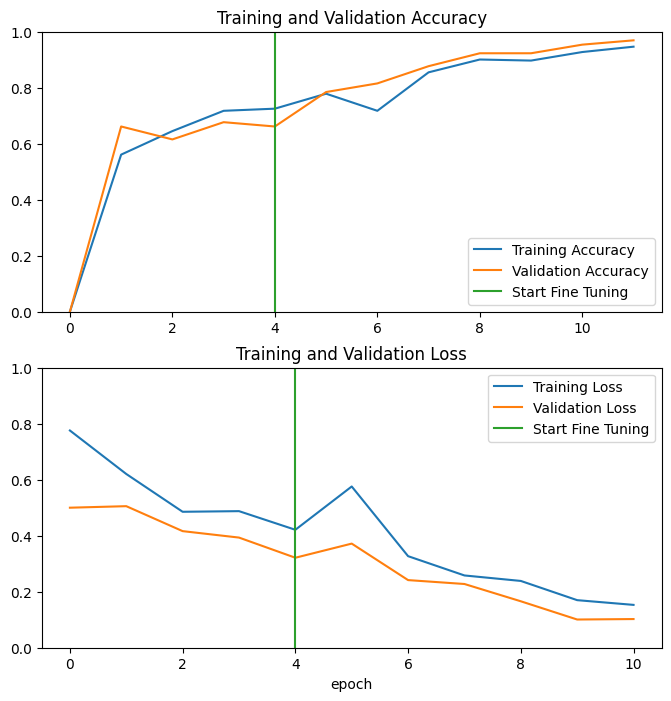

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()